In [1]:
require('ggplot2')
require('nls.multstart')
require('broom')
require('tidyverse')
require('rTPC')
require('dplyr')
require('data.table')
require('car')
require('boot')
require('patchwork')
require('minpack.lm')
require("tidyr")
require('purrr')
# update.packages(ask = FALSE)

rm(list=ls())
graphics.off()
setwd("/home/primuser/Documents/VByte/VecMismatchPaper1/code/")

Loading required package: ggplot2

Loading required package: nls.multstart

Loading required package: broom

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: rTPC

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



In [2]:
#take a look at the different models available
get_model_names()

[1] "beta_2012"             "boatman_2017"          "briere2_1999"         
 [4] "delong_2017"           "flinn_1991"            "gaussian_1987"        
 [7] "hinshelwood_1947"      "joehnk_2008"           "johnsonlewin_1946"    
[10] "kamykowski_1985"       "lactin2_1995"          "modifiedgaussian_2006"
[13] "oneill_1972"           "pawar_2018"            "quadratic_2008"       
[16] "ratkowsky_1983"        "rezende_2019"          "sharpeschoolfull_1981"
[19] "sharpeschoolhigh_1981" "sharpeschoollow_1981"  "spain_1982"           
[22] "thomas_2012"           "thomas_2017"           "weibull_1995"

In [3]:
#read in the trait data
final_trait_data <- read.csv('../data/Final_Traitofinterest.csv')

In [4]:
#filter out sets that less than the required parameters for schoolfield-high ()
final_trait_data <- dplyr::filter(final_trait_data,
                                  originaltraitname != 'Adult survival' &
                                    originalid != 'MSS0059' &
                                    originaltraitname != 'Adult longevity (female, bloodfed)' &
                                    originaltraitname != 'Adult longevity (male)' &
                                    originaltraitname != 'Adult survival (female, bloodfed)' &
                                    originaltraitname != 'Adult survival (male)' )

In [5]:
#remove completely irrelevant columns 
df <- final_trait_data[,colSums(is.na(final_trait_data))<nrow(final_trait_data)]

In [6]:
#filter to single species and trait
df2 <- dplyr::filter(df, originalid == 'csm7I')

In [7]:
df1 <- df %>%
  select('originalid', 'originaltraitname', 'originaltraitunit', 'originaltraitvalue', 'interactor1', 'ambienttemp')

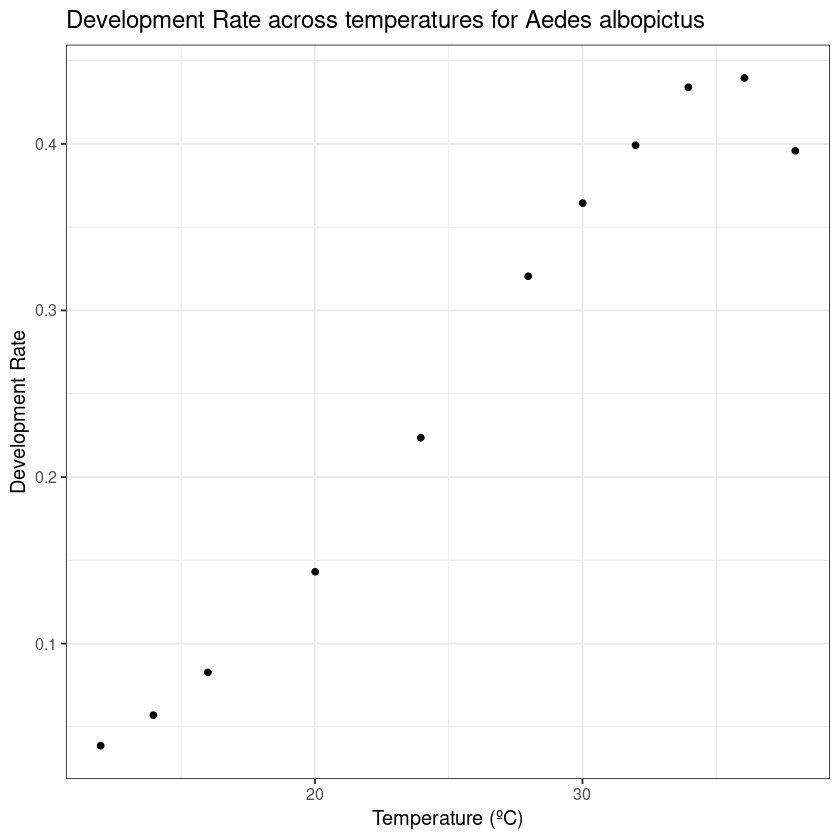

In [8]:
#visualize
ggplot(df2, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Development Rate',
       title = 'Development Rate across temperatures for Aedes albopictus')

In [9]:
#filter to single species and trait
df2 <- dplyr::filter(df, originalid == 'csm7I')

In [10]:
df1 <- df %>%
  dplyr::select('originalid', 'originaltraitname', 'originaltraitunit', 'originaltraitvalue', 'interactor1', 'ambienttemp')
#filter to single species and trait
df2 <- dplyr::filter(df1, originalid == 'csm7I')

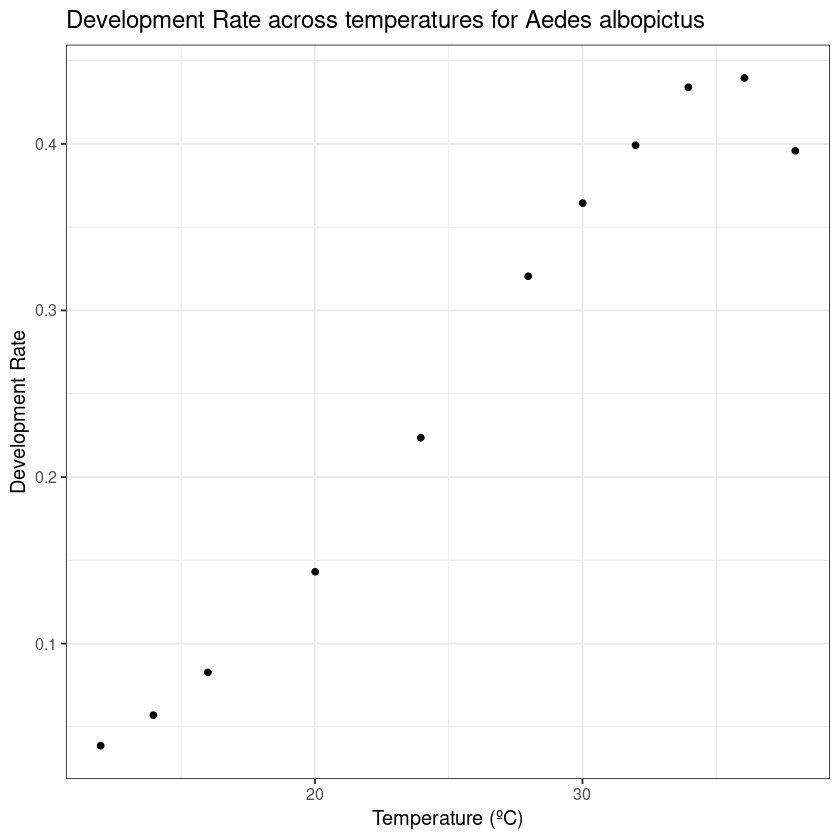

In [11]:
#visualize
ggplot(df2, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Development Rate',
       title = 'Development Rate across temperatures for Aedes albopictus')

In [12]:
# choose model
mod = 'sharpschoolhigh_1981'
#mutate the titles because I am lazy and I don't want to change the formula
d<- df2 %>%
  rename(temp = ambienttemp,
         rate = originaltraitvalue)
# fit Sharpe-Schoolfield model
d_fit <- nest(d, data = c(temp, rate)) %>%
  mutate(sharpeschoolhigh = map(data, ~nls_multstart(rate~sharpeschoolhigh_1981(temp = temp, r_tref,e,eh,th, tref = 15),
                                                     data = .x,
                                                     iter = c(3,3,3,3),
                                                     start_lower = get_start_vals(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981') - 10,
                                                     start_upper = get_start_vals(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981') + 10,
                                                     lower = get_lower_lims(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981'),
                                                     upper = get_upper_lims(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981'),
                                                     supp_errors = 'Y',
                                                     convergence_count = FALSE)),
         
         # create new temperature data
         new_data = map(data, ~tibble(temp = seq(min(.x$temp), max(.x$temp), length.out = 100))),
         # predict over that data,
         preds =  map2(sharpeschoolhigh, new_data, ~augment(.x, newdata = .y)))

In [13]:
# unnest predictions
d_preds <- select(d_fit, preds) %>%
  unnest(preds)

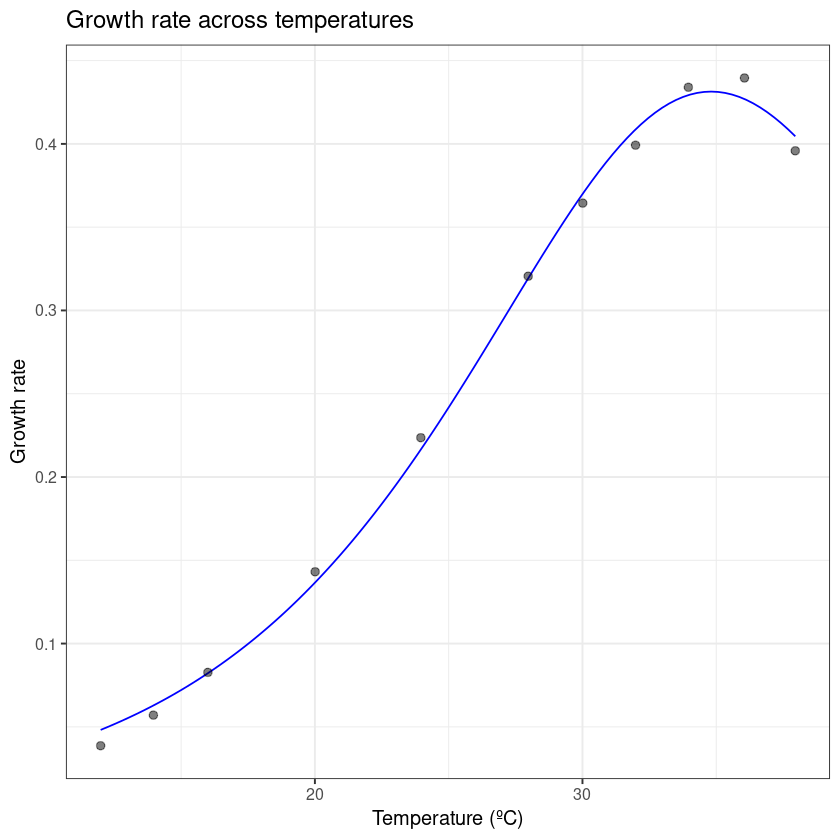

In [14]:
# plot data and predictions
ggplot() +
  geom_line(aes(temp, .fitted), d_preds, col = 'blue') +
  geom_point(aes(temp, rate), d, size = 2, alpha = 0.5) +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Growth rate',
       title = 'Growth rate across temperatures')

In [15]:
# refit model using nlsLM
fit_nlsLM <- minpack.lm::nlsLM(rate~sharpeschoolhigh_1981(temp = temp, r_tref,e,eh,th, tref = 15),
                               data = d,
                               start = coef(d_fit$sharpeschoolhigh[[1]]),
                               lower = get_lower_lims(d$temp, d$rate, model_name = 'sharpeschoolhigh_1981'),
                               upper = get_upper_lims(d$temp, d$rate, model_name = 'sharpeschoolhigh_1981'),
                               weights = rep(1, times = nrow(d)))

In [16]:
# bootstrap using case resampling
boot1 <- Boot(fit_nlsLM, method = 'case')

Warning message in nls.lm(par = start, fn = FCT, jac = jac, control = control, lower = lower, :
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


In [17]:
# look at the data
head(boot1$t)

r_tref     e         eh       th      
[1,] 0.07063864 1.0053869 1.874912 33.91542
[2,] 0.07548087 1.2405693 1.354708 27.80530
[3,] 0.05795250 0.9512028 2.581735 36.71503
[4,] 0.07072640 0.9470250 2.057355 35.26580
[5,] 0.07085801 0.9233004 2.076732 35.80000
[6,] 0.07037920 1.0263850 1.759150 33.38711

Warning message in norm.inter(t, adj.alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, adj.alpha):
“extreme order statistics used as endpoints”


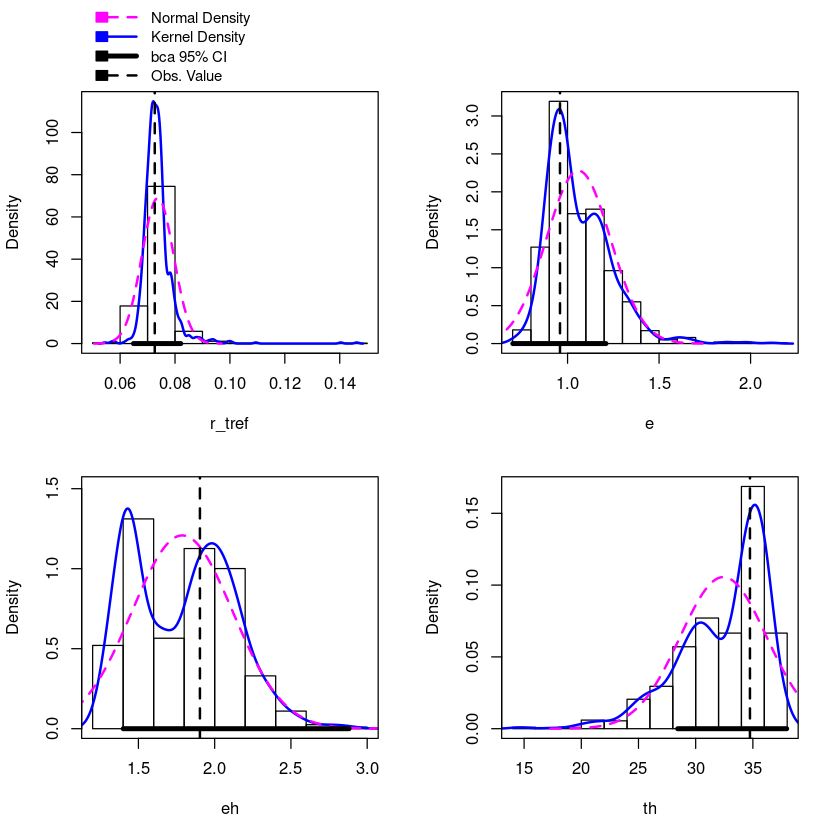

In [18]:
hist(boot1, layout = c(2,2))

In [19]:
# create predictions of each bootstrapped model
boot1_preds <- boot1$t %>%
  as.data.frame() %>%
  drop_na() %>%
  mutate(iter = 1:n()) %>%
  group_by_all() %>%
  do(data.frame(temp = seq(min(d$temp), max(d$temp), length.out = 100))) %>%
  ungroup() %>%
  mutate(pred = sharpeschoolhigh_1981(temp, r_tref, e, eh, th, tref = 15))

In [20]:
# calculate bootstrapped confidence intervals
boot1_conf_preds <- group_by(boot1_preds, temp) %>%
  summarise(conf_lower = quantile(pred, 0.025),
            conf_upper = quantile(pred, 0.975)) %>%
  ungroup()

In [21]:
# plot bootstrapped CIs
p1 <- ggplot() +
  geom_line(aes(temp, .fitted), d_preds, col = 'blue') +
  geom_ribbon(aes(temp, ymin = conf_lower, ymax = conf_upper), boot1_conf_preds, fill = 'blue', alpha = 0.3) +
  geom_point(aes(temp, rate), d, size = 2, alpha = 0.5) +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Growth rate',
       title = 'Growth rate across temperatures')

# plot bootstrapped predictions
p2 <- ggplot() +
  geom_line(aes(temp, .fitted), d_preds, col = 'blue') +
  geom_line(aes(temp, pred, group = iter), boot1_preds, col = 'blue', alpha = 0.007) +
  geom_point(aes(temp, rate), d, size = 2, alpha = 0.5) +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Growth rate',
       title = 'Growth rate across temperatures')

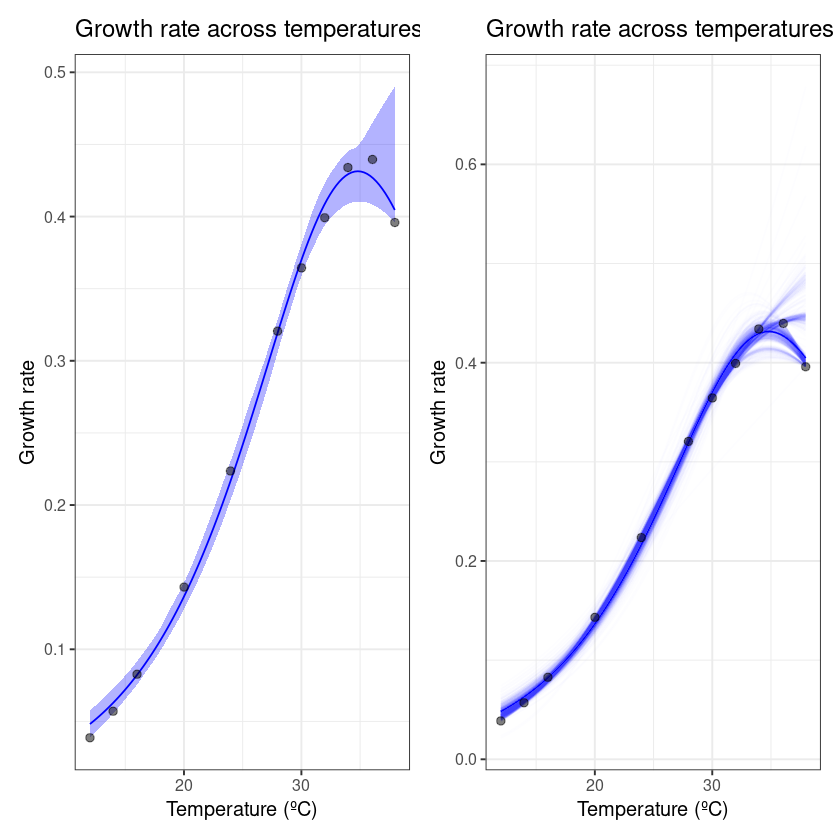

In [22]:
p1 + p2